# Flow Matching "Hello World" Notebook

This notebook implements **Flow Matching** from scratch on a simple 2D dataset.

**Goal:** Learn a vector field $ v_\theta(x,t) $ that transports a standard Gaussian distribution to a data distribution along a simple linear path.

##  Structure:
 1. Imports & Configuration  
 2. Define Toy Dataset (Mixture of Gaussians)  
 3. Define Neural Velocity Network  
 4. Define Probability Path & Target Velocity  
 5. Training Loop (Flow Matching Loss)  
 6. Sampling via ODE (RK4 Integration)  
 7. Visualisation of Results


## Import and Configurations

In [10]:
import math
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set up basic config
@dataclass
class CFG:
    dim: int = 2                    # Dimensionality of data (2D toy)
    batch_size: int = 4096
    steps: int = 6000
    lr: float = 2e-4
    device: str = "cuda" if torch.cuda.is_available() else "mps"
    plot_every: int = 1000
    n_steps_sample: int = 100       # Number of ODE steps for sampling
    seed: int = 0
    # Mixture of Gaussians parameters
    n_modes: int = 8
    radius: float = 4.0
    mode_std: float = 0.25

cfg = CFG()
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)

print(f"Using device: {cfg.device}")


Using device: mps


# Toy Dataset — Mixture of Gaussians on a Circle

We define a simple **data distribution** consisting of several Gaussians placed on a circle.
This makes it easy to visualise how well the learned flow matches the target distribution.

- **`sample_data(batch)`** samples from the mixture (data).
- **`sample_noise(batch)`** samples from standard normal (prior).


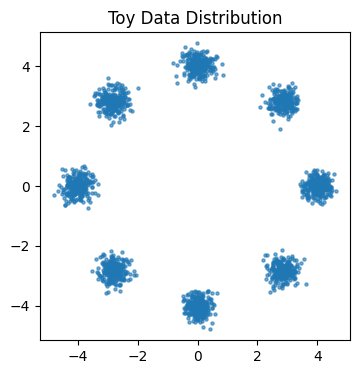

In [3]:
def sample_data(batch: int, device: str):
    """Sample x ~ p_data (mixture of K Gaussians arranged on a circle)."""
    K = cfg.n_modes
    k = torch.randint(0, K, (batch,), device=device)
    angles = 2 * math.pi * (k.float() / K)
    centers = torch.stack([cfg.radius * torch.cos(angles),
                           cfg.radius * torch.sin(angles)], dim=1)
    x = centers + cfg.mode_std * torch.randn(batch, 2, device=device)
    return x

def sample_noise(batch: int, dim: int, device: str):
    return torch.randn(batch, dim, device=device)

# Quick visualisation of data samples
x_vis = sample_data(2000, cfg.device).cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(x_vis[:,0], x_vis[:,1], s=5, alpha=0.6)
plt.title("Toy Data Distribution")
plt.axis("equal"); plt.show()


##  Neural Velocity Network $ v_\theta(x,t) $

We define a simple **MLP** that takes as input:
- a point $ x_t \in \mathbb{R}^2 $
- a scalar time $ t \in [0,1] $

and outputs the predicted velocity $ v_\theta(x_t, t) $ at that point.
Time is concatenated as an extra feature.


In [4]:
class VelocityNet(nn.Module):
    def __init__(self, dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))

    def forward(self, x, t):
        # x: (B, dim), t: (B,) scalar times
        t = t.unsqueeze(-1)
        return self.net(torch.cat([x, t], dim=-1))

vnet = VelocityNet(cfg.dim).to(cfg.device)
opt = torch.optim.AdamW(vnet.parameters(), lr=cfg.lr, betas=(0.9, 0.99), weight_decay=1e-4)


# Probability Path & Target Velocity
 We pick the **simplest path**:
 $$
 x_t = (1 - t) z + t x
 $$

 - This linearly interpolates between noise `z` (at t=0) and data `x` (at t=1).  
 - The **true velocity** along this path is constant:
 $$
 \dot x_t = x - z
 $$

 We can then sample `(z, x, t)`, construct `x_t`, compute the target velocity, and regress the network to it.


In [5]:
def alpha(t):    # schedule α(t) = t
    return t

def interpolate(z, x, t):
    a = alpha(t).unsqueeze(-1)
    return (1 - a) * z + a * x

def target_velocity(z, x, t):
    # For α(t)=t, derivative = x - z
    return x - z


##  Training Loop (Flow Matching Loss)

The **Flow Matching loss** is simply:

$$
\mathcal{L}(\theta) = \mathbb{E}_{x,z,t} \big\| v_\theta(x_t, t) - \dot x_t \big\|^2
$$

where $ x_t $ is the interpolated point and $ \dot x_t $ is the true velocity.

This is just a regression loss — no score matching, no SDE, no log-density terms.

In [6]:
def train():
    vnet.train()
    for step in range(1, cfg.steps+1):
        x = sample_data(cfg.batch_size, cfg.device)
        z = sample_noise(cfg.batch_size, cfg.dim, cfg.device)
        t = torch.rand(cfg.batch_size, device=cfg.device)

        x_t = interpolate(z, x, t)
        v_star = target_velocity(z, x, t)
        v_pred = vnet(x_t, t)

        loss = F.mse_loss(v_pred, v_star)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vnet.parameters(), 1.0)
        opt.step()

        if step % 500 == 0:
            print(f"[{step:04d}] loss={loss.item():.6f}")

        if step % cfg.plot_every == 0 or step == cfg.steps:
            with torch.no_grad():
                plot_samples(step)

# Helper for plotting samples
@torch.no_grad()
def plot_samples(step):
    z0 = sample_noise(2000, cfg.dim, cfg.device)
    samples = sample_with_rk4(z0, n_steps=cfg.n_steps_sample).cpu()
    data = sample_data(2000, cfg.device).cpu()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.scatter(data[:,0], data[:,1], s=5, alpha=0.5)
    plt.axis('equal'); plt.title(f"Real Data")

    plt.subplot(1,2,2)
    plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.5, c='orange')
    plt.axis('equal'); plt.title(f"Generated (step {step})")
    plt.tight_layout()
    plt.show()


## ODE Sampling (RK4 Integration)

Once trained, we generate samples by solving the ODE

$
\frac{dx}{dt} = v_\theta(x,t), \quad x(0)=z \sim \mathcal{N}(0,I).
$

We use **Runge–Kutta 4 (RK4)** for stable integration.


In [ ]:
def rk4_step(f, x, t, h):
    k1 = f(x, t)
    k2 = f(x + 0.5*h*k1, t + 0.5*h)
    k3 = f(x + 0.5*h*k2, t + 0.5*h)
    k4 = f(x + h*k3, t + h)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

@torch.no_grad()
def sample_with_rk4(z0, n_steps=100):
    vnet.eval()
    B = z0.shape[0]
    x = z0.clone()
    h = 1.0 / n_steps

    def f(x_cur, t_scalar):
        t_vec = torch.full((B,), t_scalar, device=z0.device)
        return vnet(x_cur, t_vec)

    t = 0.0
    for _ in range(n_steps):
        x = rk4_step(f, x, t, h)
        t += h
    return x


[0500] loss=4.015974
[1000] loss=3.754294


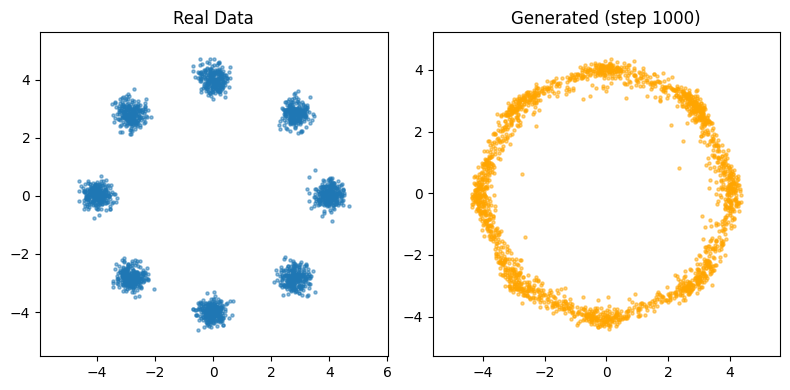

[1500] loss=3.763409
[2000] loss=3.848203


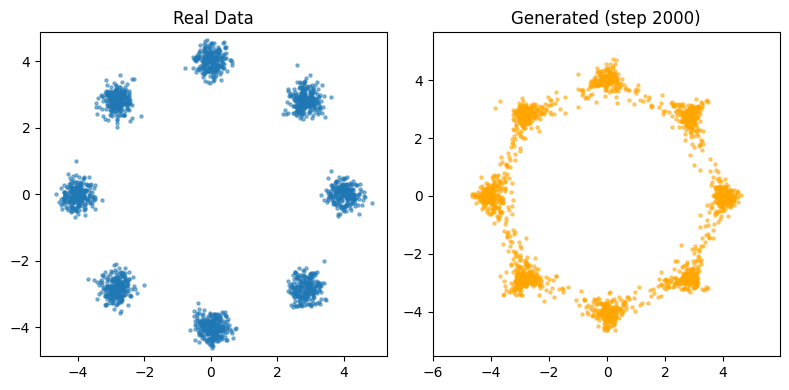

[2500] loss=3.677472
[3000] loss=3.679447


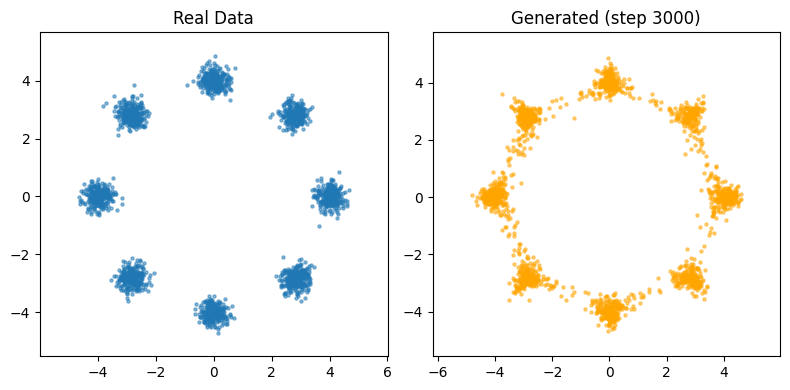

[3500] loss=3.729825
[4000] loss=3.703333


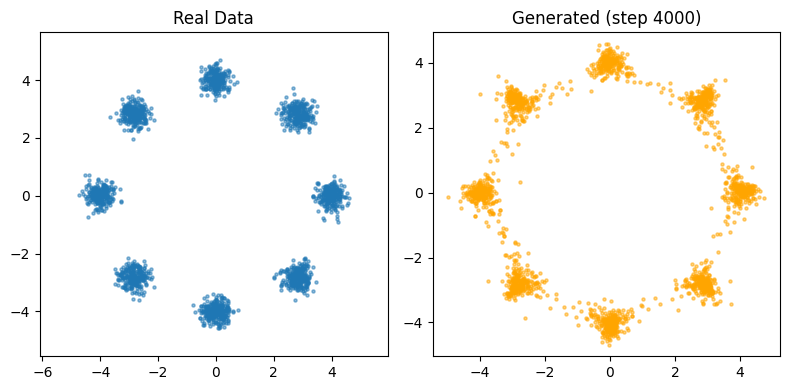

[4500] loss=3.620589
[5000] loss=3.685988


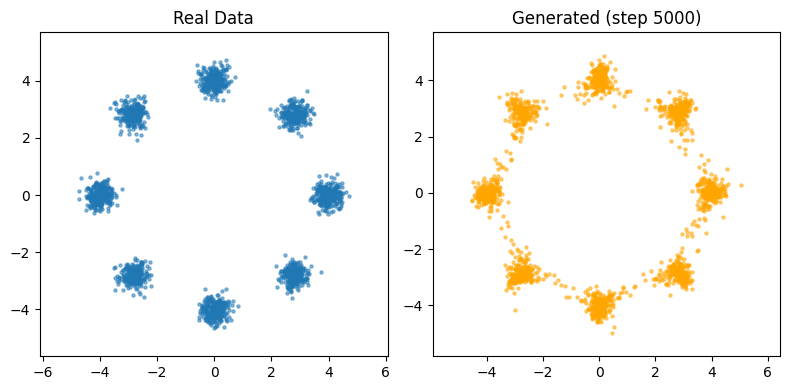

[5500] loss=3.615633
[6000] loss=3.621209


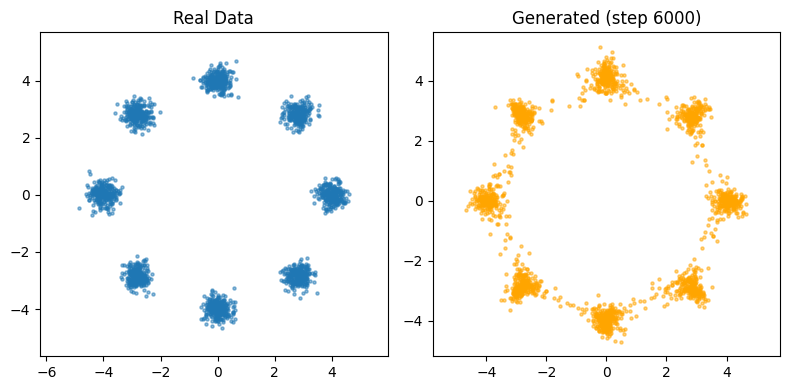

In [8]:
train()


In [11]:
# Compare means / covariances between real and generated
x_real = sample_data(10_000, cfg.device).cpu().numpy()
x_gen = sample_with_rk4(sample_noise(10_000, cfg.dim, cfg.device)).cpu().numpy()

print("Real mean:", x_real.mean(axis=0))
print("Gen  mean:", x_gen.mean(axis=0))

print("Real cov:\n", np.cov(x_real.T))
print("Gen  cov:\n", np.cov(x_gen.T))


Real mean: [-0.06102989 -0.00586918]
Gen  mean: [-0.02382987 -0.09259413]
Real cov:
 [[8.06886464 0.08445035]
 [0.08445035 8.0531168 ]]
Gen  cov:
 [[ 7.83390456 -0.05445434]
 [-0.05445434  8.26959588]]
